In [1]:
# imports 

from pathlib import Path
from typing import Union

import os
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import copy
from torchvision import transforms
from torchvision.datasets import ImageFolder

import torch
import csv
import random
import numpy as np
from PIL import Image 
from tqdm import tqdm

import sys
sys.path.append(r'/home/afroehli/coding/util_scripts')
from utils_dataloading.dassl_datum_mod import DatumWithWnid 
from utils_dataloading.imagenet_tree import ImagenetSemanticInfo, ImagenetSemanticSubtree

sys.path.append(r'/home/afroehli/coding/OOD-X-Benchmarks')
from datasets import imagenet_x as i_x, imagenet_r_x as r_x, imagenet_c_x as c_x, imagenet_v2_x as v2_x

# other setup
random.seed(3)

In [2]:

# load model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')

dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14.eval()
dinov2_vits14.to(device)

transform = transforms.Compose([transforms.Resize((154, 210)),
                                transforms.ToTensor()])


# load semantic-info object
with open(r'/home/afroehli/coding/pickle_data/imagenet_semantic_info.pkl', 'rb') as pkl_file:
    semantic_info = pickle.load(pkl_file)


# load classes that are common in all imagenet variances 
wnids_common_classes = set()
with open('/home/afroehli/coding/dinov2_ood/storage/union_set_classes.txt', 'r') as union_file: 
    for line in union_file.readlines():
        common_wnid = line.rstrip('\n')
        wnids_common_classes.add(common_wnid)

print(f'Common classes found: {len(wnids_common_classes)}')
for n, common_class_wnid in enumerate(wnids_common_classes): 
    print(f'{n + 1}: {semantic_info.wnid_to_classname[common_class_wnid]}') 

# only in case model output was stored before
# load already calculated embeddings

datasets_dict = {
        'imagenet_x': {'filename': 'imagenet_x_val_results.pkl', 'sorted_classes': None, 'model_results' : None},
        'imagenet_x_train': {'filename': 'imagenet_x_train_results.pkl', 'sorted_classes': None, 'model_results' : None}, 
        'imagenet_r': {'filename': 'imagenet_r_results.pkl', 'sorted_classes': None, 'model_results': None}, 
        'imagenet_v2': {'filename': 'imagenet_v2_results.pkl', 'sorted_classes': None, 'model_results': None}, 
        'imagenet_c': {'filename': 'imagenet_c_results.pkl', 'sorted_classes': None, 'model_results': None}
}

with open('/home/afroehli/coding/pickle_data/dinov2_ood_datasets_dict.pkl', 'rb') as pickle_file:
    datasets_dict = pickle.load(pickle_file)


# for dataset_name in datasets_dict.keys():
#     try:
#         if datasets_dict[dataset_name]['sorted_classes'] == None:
#             print(f'Try to load dataset: {dataset_name}')
#             with open(f'/home/afroehli/coding/pickle_data/dataset_objects/{dataset_name}_sorted.pkl', 'rb') as pickle_file: 
#                 datasets_dict[dataset_name]['sorted_classes'] = pickle.load(pickle_file)
#     except FileNotFoundError:
#         print(f'Dataset-file was not found: {dataset_name}_sorted.pkl')
#         datasets_dict[dataset_name]['sorted_classes'] = None

#     try:
#         if datasets_dict[dataset_name]['model_results'] == None:
#             print(f'Try to load model-results for: {dataset_name}')
#             model_results_fname = f'/home/afroehli/coding/pickle_data/model_output/{datasets_dict[dataset_name]['filename']}'
#             with open(model_results_fname, 'rb') as pickle_file:
#                 datasets_dict[dataset_name]['model_results'] = pickle.load(pickle_file)
#     except FileNotFoundError: 
#         print(f'Model-results file could not be found: {model_results_fname}')
#         datasets_dict[dataset_name]['model_results'] = None



model_res_loaded = [dset for dset in datasets_dict.keys() if datasets_dict[dset]['model_results'] !=  None]
model_res_not_loaded = [dset for dset in datasets_dict.keys() if datasets_dict[dset]['model_results'] ==  None]

print(f'Following datasets were loaded: {model_res_loaded}')
print(f'Following datasets are missing: {model_res_not_loaded}')

Device used: cuda


Using cache found in /home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Common classes found: 135
1:  clownfish
2:  lorikeet
3:  skunk
4:  beer glass
5:  guinea pig
6:  pig
7:  praying mantis
8:  Cocker Spaniel
9:  French Bulldog
10:  red fox
11:  chameleon
12:  zebra
13:  Shih Tzu
14:  axolotl
15:  Scottish Terrier
16:  castle
17:  baboon
18:  wheelbarrow
19:  cottontail rabbit
20:  smooth newt
21:  Chow Chow
22:  carousel
23:  basketball
24:  junco
25:  hermit crab
26:  king penguin
27:  bald eagle
28:  goldfinch
29:  badger
30:  tabby cat
31:  hammerhead shark
32:  fly
33:  bucket
34:  Siberian Husky
35:  sea lion
36:  toucan
37:  Bloodhound
38:  goldfish
39:  pug
40:  great white shark
41:  cowboy hat
42:  ambulance
43:  St. Bernard
44:  gorilla
45:  grey whale
46:  ant
47:  duck
48:  lion
49:  scorpion
50:  cockroach
51:  hummingbird
52:  tree frog
53:  centipede
54:  leopard
55:  Toy Poodle
56:  gazelle
57:  hyena
58:  chimpanzee
59:  pelican
60:  German Shepherd Dog
61:  Indian cobra
62:  canoe
63:  Rottweiler
64:  Afghan Hound
65:  snail
66:  Pembr

In [ ]:
# with open('/home/afroehli/coding/pickle_data/dinov2_ood_datasets_dict_OLD.pkl', 'wb') as pickle_file:
#             pickle.dump(datasets_dict, pickle_file, pickle.HIGHEST_PROTOCOL)

# for dataset in ['imagenet_x', 'imagenet_v2', 'imagenet_r', 'imagenet_c']:
#         datasets_dict[dataset]['model_results'] = None

In [ ]:
# compute closest class for each common class 

# for each common-class, find closest class in rest of imagenet-1k (999 candidates)

common_class_comparisons = dict()
imagenet_wnids = list(imagenet_x_val_results.keys())

print(f'Number of detected common-wnids: {len(wnids_common_classes)}')
print(f'Number of detected imagenet-wnids: {len(imagenet_wnids)}')

for common_wnid in wnids_common_classes:

    # calculate mean of model-output for this class 
    ood_mean = np.mean(imagenet_x_val_results[common_wnid], axis=0)

    imagenet_wnids.remove(common_wnid)
    for class_wnid in imagenet_wnids: 

        # calculate mean of selected class
        class_mean = np.mean(imagenet_x_val_results[class_wnid], axis=0)
        diff_ood = np.abs(ood_mean - class_mean)
        sum_class_diff = np.sum(diff_ood)
        try:
            common_class_comparisons[common_wnid].append((sum_class_diff, class_wnid))
        except KeyError:
            common_class_comparisons[common_wnid] = [(sum_class_diff, class_wnid)]

    # sort calculated mean differences
    common_class_comparisons[common_wnid].sort(key = lambda ood_id: ood_id[0])
    imagenet_wnids.append(common_wnid)

Number of detected common-wnids: 135
Number of detected imagenet-wnids: 1000


In [ ]:
# control output of closest classes 

for n, common_wnid in enumerate(common_class_comparisons.keys()):

    top_three = common_class_comparisons[common_wnid][:3]
    top_three_names = [(semantic_info.wnid_to_classname[tt_wnid], tt_score) for tt_score, tt_wnid in top_three]
    print(f'{n}: CC-Class = {semantic_info.wnid_to_classname[common_wnid]}, Next classes = {top_three_names}')

In [10]:
# store class split 

with open('/home/afroehli/coding/dinov2_ood/storage/class_split.csv', 'w', newline='') as class_split_table:
    split_writer = csv.writer(class_split_table, delimiter=';')

    for common_wnid in common_class_comparisons.keys():
        closest_class_wnid = common_class_comparisons[common_wnid][0][1]
        split_writer.writerow([common_wnid, closest_class_wnid])


In [3]:
# load class pairs 

closest_classes = [] 
    

with open('/home/afroehli/coding/dinov2_ood/storage/class_split.csv', 'r')as class_split_table:
    split_reader = csv.reader(class_split_table, delimiter=';')
    for n, table_row in enumerate(split_reader):
        class_1 = table_row[0]
        class_2 = table_row[1]
        new_combination = (class_1, class_2)
        closest_classes.append(new_combination)



In [4]:
# util functions  

def get_random_class() -> str:
    all_classes = list(datasets_dict['imagenet_x']['sorted_classes'].keys())
    n_classes = len(all_classes)
    next_int = random.randint(0, n_classes - 1)
    next_class = all_classes[next_int]

    return next_class

In [ ]:
imagenet_train_dataset = ImageFolder(root='/home/afroehli/coding/OOD-X-Benchmarks/data/imagenet/images/train', transform=transform)

print(type(imagenet_train_dataset))
print(len(imagenet_train_dataset))


<class 'torchvision.datasets.folder.ImageFolder'>
1281167


In [15]:
print(type(imagenet_train_dataset[0]))
print(len(imagenet_train_dataset[0]))
print(type(imagenet_train_dataset[0][0]))
print(type(imagenet_train_dataset[0][1]))
print(imagenet_train_dataset[1299][1])

<class 'tuple'>
2
<class 'torch.Tensor'>
<class 'int'>
0


In [ ]:
# RECREATION could cause a new order of directories

# with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_train_class_to_index_mapping.csv', 'w', newline='') as class_index_table: 
#     class_index_writer = csv.writer(class_index_table, delimiter=';')

#     imagenet_classes_wnids = os.listdir('/home/afroehli/coding/OOD-X-Benchmarks/data/imagenet/images/train')

#     for n, wnid in enumerate(imagenet_classes_wnids):
#         class_index_writer.writerow([wnid, n])

In [22]:
# only load already calculated classes, when calculation was interrupted

# list for mapping indexes to wnids
imagenet_class_list = []
with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_train_class_to_index_mapping.csv', 'r') as class_index_table:
    class_index_reader = csv.reader(class_index_table, delimiter=';')
    for table_row in class_index_reader:
        imagenet_class_list.append(table_row[0])

class CustomizedImageFolder(ImageFolder): 

    def __init__(self, not_processed_imagenet_classes = None, root = None, transform = None):
        self.not_processed_imagenet_classes = not_processed_imagenet_classes 
        super().__init__(root = root, transform = transform)

    def find_classes(self, directory: Union[str, Path]) -> tuple[list[str], dict[str, int]]:

        class_list = []
        class_index_dict = dict()
    
        with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_train_class_to_index_mapping.csv', 'r') as class_index_table:


            class_index_reader = csv.reader(class_index_table, delimiter=';')
            for table_row in class_index_reader:
                class_wnid = table_row[0]
                class_index = table_row[1]

                if class_wnid in self.not_processed_imagenet_classes:
                    class_list.append(class_wnid)
                    class_index_dict[class_wnid] = class_index

        return class_list, class_index_dict
    
with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_x_train_results_dump.pkl', 'rb') as pickle_file:
    datasets_dict['imagenet_x_train']['model_results'] = pickle.load(pickle_file)


with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_x_train_processed_classes.pkl', 'rb') as pickle_file:
    already_processed_wnids = pickle.load(pickle_file)
    
with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_x_train_processed_classes_copy.pkl', 'wb') as pickle_file:
    pickle.dump(already_processed_wnids, pickle_file, pickle.HIGHEST_PROTOCOL)

wnids_to_be_processed = set(datasets_dict['imagenet_x']['model_results'].keys()) - already_processed_wnids

imagenet_train_dataset = CustomizedImageFolder(not_processed_imagenet_classes=wnids_to_be_processed, 
                                               root = '/home/afroehli/coding/OOD-X-Benchmarks/data/imagenet/images/train', 
                                               transform=transform)



imagenet_train_dataset_loader = torch.utils.data.DataLoader(imagenet_train_dataset, batch_size=128, 
                                                            shuffle=False, num_workers=8, pin_memory=True)

print(f'Number of Imagenet-classes to be processed: {len(wnids_to_be_processed)}')
print(f'Dataset-size: {len(imagenet_train_dataset)}')
print(f'Dataloader-size: {len(imagenet_train_dataset_loader)}')


Number of Imagenet-classes to be processed: 595
Dataset-size: 761171
Dataloader-size: 5947


296
Wnid is: n01532829


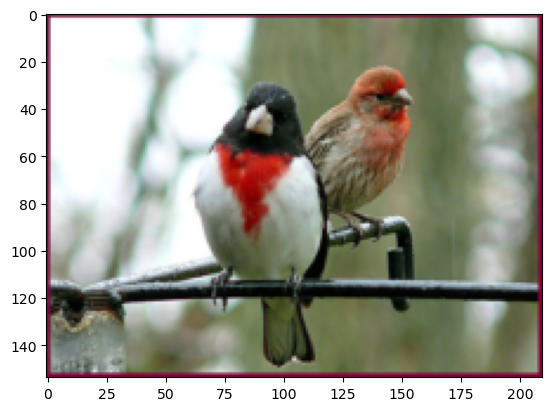

In [18]:
data_index = 2600
print(imagenet_train_dataset[data_index][1])
print(f'Wnid is: {imagenet_class_list[int(imagenet_train_dataset[data_index][1])]}')

img_tensor = imagenet_train_dataset[data_index][0].detach().numpy()
img_array = np.squeeze(img_tensor)
img_array = np.transpose(img_array, (1, 2, 0))
plt.imshow(img_array)
plt.show()

In [20]:

expected_instances_per_class = dict()
imagenet_wnids = os.listdir('/home/afroehli/coding/OOD-X-Benchmarks/data/imagenet/images/train')

for wnid in imagenet_wnids:
    number_instances = len(os.listdir(f'/home/afroehli/coding/OOD-X-Benchmarks/data/imagenet/images/train/{wnid}'))
    expected_instances_per_class[wnid] = number_instances 

for n, wnid in enumerate(expected_instances_per_class.keys()):
    if expected_instances_per_class[wnid] != 1300:
        print(f'{wnid}: {expected_instances_per_class[wnid]}')

n03400231: 1222
n03314780: 1153
n04485082: 1160
n02095314: 977
n03956157: 1270
n01704323: 1266
n01744401: 1071
n04201297: 1249
n03814639: 1180
n03781244: 1155
n03498962: 891
n03133878: 1187
n03447721: 1282
n02783161: 1236
n02110627: 954
n02112706: 1070
n04266014: 1238
n03062245: 1154
n02090379: 1290
n03075370: 1216
n02088632: 1136
n02817516: 1209
n03803284: 1133
n04591157: 1213
n07730033: 1125
n04040759: 1253
n03658185: 986
n03970156: 1254
n02087046: 860
n03920288: 962
n03706229: 1155
n03947888: 1118
n04311004: 1153
n03041632: 1067
n03843555: 1120
n02093647: 1258
n02095889: 936
n02356798: 1206
n02708093: 1292
n02085782: 772
n04125021: 1029
n02066245: 1150
n04479046: 1053
n04525038: 1062
n04429376: 976
n02089078: 732
n02978881: 1186
n02102973: 969
n03961711: 1053
n03764736: 1097
n02916936: 1176
n04579145: 1055
n01873310: 1272
n02096437: 1156
n02113978: 755
n07932039: 1193
n04418357: 1264
n03995372: 908
n04370456: 931
n07248320: 1154
n02089973: 754
n04238763: 1162
n02093859: 1273
n075841

In [21]:
# calculate embedding for new classes 

# TODO 
# use batches from dataloader for calculating embeddings 
# use control mechanism to check that only for needed classes embeddings are calculated 
# number of embeddings per class must be equalt to number of images per class 

import time 

check_processed_classes = set()
n_batches_per_class = dict()

for dataset_name in datasets_dict.keys():
        
        if dataset_name == 'imagenet_x_train':

            model_results = datasets_dict[dataset_name]['model_results']

            print(f'Next calculate results for dataset: {dataset_name}')

            # dataset_wnids = list(dataset.keys())

            finished_classes = 0
            batch_process_times = []

            for batch in (pbar := tqdm(imagenet_train_dataset_loader, ncols=100)):

                start_batch_process = time.perf_counter()

                batch_transferred = batch[0].to(device)
                model_out = dinov2_vits14(batch_transferred)

                wnid_per_batch_item = [imagenet_class_list[int(batch_item_index)] for batch_item_index in batch[1]]

                for n, processed_batch_item in enumerate(model_out):
                    batch_item_wnid = wnid_per_batch_item[n]
                    try: 
                        model_results[batch_item_wnid].extend(list(processed_batch_item.cpu().detach().numpy()))
                        check_processed_classes.add(batch_item_wnid)
                        n_batches_per_class[batch_item_wnid] += 1
                    except KeyError:
                        model_results[batch_item_wnid] = list(processed_batch_item.cpu().detach().numpy())
                        n_batches_per_class[batch_item_wnid] = 1
                        
                end_batch_process = time.perf_counter()
                batch_process_times.append(end_batch_process - start_batch_process)

                wnids_batch = set(wnid_per_batch_item)

                for wnid in wnids_batch: 
                     
                     if n_batches_per_class[batch_item_wnid] == 1300: 
                         print(f'1300 instances processed for class *{wnid}*, modelresults-length: {len(model_results[wnid])}, expected length: {expected_instances_per_class[wnid]}')
                     
                     if len(model_results[wnid]) == expected_instances_per_class[wnid]:
                        with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_x_train_results_dump.pkl', 'wb') as pickle_file: 
                            pickle.dump(model_results, pickle_file, pickle.HIGHEST_PROTOCOL)
                            
                        already_processed_wnids.add(wnid)
                        with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_x_train_processed_classes.pkl', 'wb') as pickle_file:
                            pickle.dump(already_processed_wnids, pickle_file, pickle.HIGHEST_PROTOCOL)

                        finished_classes += 1
                        if finished_classes % 5 == 0:
                            avg_process_time = sum(batch_process_times) / len(batch_process_times)
                            print(f'Average batch process time: {avg_process_time}')

            # assign temporary model-result storage to general result dictionary
            datasets_dict[dataset_name]['model_results'] = model_results 

Next calculate results for dataset: imagenet_x_train


 11%|██████▋                                                     | 658/5947 [04:23<25:15,  3.49it/s]

1300 instances processed for class *n01990800*, modelresults-length: 499200, expected length: 1300


 12%|███████                                                     | 698/5947 [05:15<39:34,  2.21it/s]


KeyboardInterrupt: 

In [13]:
# check if new batch calculation is same as old calculation 

not_same_emb = 0 
same_emb = 0 
mean_not_equal = 0

for wnid in imagenet_v2_results_test.keys():

    total_test = len(imagenet_v2_results_test[wnid])
    type_test = type(imagenet_v2_results_test[wnid])

    total_expected = len(datasets_dict['imagenet_v2']['model_results'][wnid])
    type_expected = type(datasets_dict['imagenet_v2']['model_results'][wnid])

    if total_test != total_expected:
        print(f'Different number of embeddings for: {wnid}, Test = {total_test}, Exp = {total_expected}')
        break 
    if type_test != type_expected:
        print(f'Different types between results for: {wnid}, Test-type = {type_test}, Exp-type = {type_expected}')
        break 
    
    mean_test = np.mean(np.array(imagenet_v2_results_test[wnid]), axis = 0)
    mean_exp = np.mean(np.array(datasets_dict['imagenet_v2']['model_results'][wnid]), axis = 0)

    try:
        np.testing.assert_array_almost_equal(mean_test, mean_exp, decimal=6)
    except AssertionError:
        mean_not_equal += 1
    
    for n, emb in enumerate(imagenet_v2_results_test[wnid]):

        test_emb = emb 
        expected_emb = datasets_dict['imagenet_v2']['model_results'][wnid][n]

        type_test_emb = type(test_emb)
        type_exp_emb = type(expected_emb)

        if type_test_emb != type_exp_emb: 
            print(f'Different types for embeddings for: {wnid}, Test-emb-type = {type_test_emb}, Exp-emb-type = {type_exp_emb}')
            break 

        if not np.array_equal(test_emb, expected_emb):
            # print(f'Not same embeddings. \nTest-emb = {test_emb}\nExpe-emb = {expected_emb}')
            not_same_emb += 1 
        else: 
            same_emb += 1 
        
print(f'Mean not equal: {mean_not_equal}')
print(f'Embedding was same: {same_emb}, was not same: {not_same_emb}')

Mean not equal: 1000
Embedding was same: 0, was not same: 10000


In [8]:
# Check dimensions of result sets 

print(f'Number of calculated classes for Imagenet-X, Expected 1000, Acutal: {len(list(datasets_dict['imagenet_x']['model_results']))}')
print(f'Number of calculated classes for Imagenet-X-Train, Expected 135, Acutal: {len(list(datasets_dict['imagenet_x_train']['model_results']))}')
print(f'Number of calculated classes for Imagenet-V2, Expected 1000, Actual: {len(list(datasets_dict['imagenet_v2']['model_results']))}')
print(f'Number of calculated classes for Imagenet-C:, Expected  521, Actual: {len(list(datasets_dict['imagenet_c']['model_results']))}')
print(f'Number of calculated classes for Imagenet-R:, Expected  200, Actual: {len(list(datasets_dict['imagenet_r']['model_results']))}')

Number of calculated classes for Imagenet-X, Expected 1000, Acutal: 1000
Number of calculated classes for Imagenet-X-Train, Expected 135, Acutal: 135
Number of calculated classes for Imagenet-V2, Expected 1000, Actual: 1000
Number of calculated classes for Imagenet-C:, Expected  521, Actual: 521
Number of calculated classes for Imagenet-R:, Expected  200, Actual: 200


In [9]:
# store complete datasets object

with open('/home/afroehli/coding/pickle_data/dinov2_ood_datasets_dict.pkl', 'wb') as pickle_file:
            pickle.dump(datasets_dict, pickle_file, pickle.HIGHEST_PROTOCOL)


In [7]:


## calculate statistics 

# general statistics on whole imagenet dataset 
# np-array with shape 1000 x 50 x 384
results_all_classes = np.array([datasets_dict['imagenet_x']['model_results'][class_wnid] for class_wnid in datasets_dict['imagenet_x']['model_results'].keys()])

mean_pictures_all_classes = np.mean(results_all_classes, axis=1)
mean_classes_all_classes = np.mean(mean_pictures_all_classes, axis=0)
mean_imagenet = mean_classes_all_classes # shape 384

statistics_dict = dict()

for inv_class, comp_class in closest_classes: 

    comb_key = (inv_class, comp_class)

    # select random compare class
    ran_comp_class = get_random_class()
    while ran_comp_class == inv_class or ran_comp_class == comp_class:
        ran_comp_class = get_random_class()

    statistics_dict[comb_key] = dict()
    statistics_dict[comb_key]['ran_comp_class'] = ran_comp_class 

    # statistics on invariant class
    inv_class_res = np.array(datasets_dict['imagenet_x']['model_results'][inv_class])
    inv_class_mean = np.mean(inv_class_res, axis=0)
    inv_class_std = np.std(inv_class_res, axis=0)

    # statistics on most similar compare class
    comp_class_res = np.array(datasets_dict['imagenet_x']['model_results'][comp_class])
    comp_class_mean = np.mean(comp_class_res, axis=0) 
    comp_class_std = np.std(comp_class_res, axis=0)
    diff_comp_inv = np.abs(comp_class_mean - inv_class_mean)

    diff_inet_mean_inv = np.abs(mean_imagenet - inv_class_mean)

    statistics_dict[comb_key] = dict()
    statistics_dict[comb_key]['counts-inet'] = dict()
    statistics_dict[comb_key]['counts'] = dict()
    statistics_dict[comb_key]['inSTD'] = dict()
    statistics_dict[comb_key]['sum'] = dict()

    # save statistics of compare class
    true_false_list = (diff_comp_inv < inv_class_std).tolist()
    comp_within_std = true_false_list.count(True)
    statistics_dict[comb_key]['inSTD']['comp'] = comp_within_std

    statistics_dict[comb_key]['sum']['comp'] = np.sum(diff_comp_inv)


    # calculate statistics for all other datasets and classes 
    for d_name, d_short, d_wnid in [('imagenet_x', 'inet', ''), ('imagenet_x', 'ranComp', ran_comp_class), 
                                    ('imagenet_r', 'inetR', inv_class), ('imagenet_v2', 'inetV2', inv_class), 
                                    ('imagenet_c', 'inetC', inv_class), ('imagenet_x', 'comp', comp_class)]: 

        if d_short != 'inet':
            d_results = np.array(datasets_dict[d_name]['model_results'][d_wnid])
            d_result_mean = np.mean(d_results, axis = 0)
            # d_result_std = np.std(d_results, axis = 0)
        else: 
            d_result_mean = mean_classes_all_classes

        

        diff_to_inv = np.abs(d_result_mean - inv_class_mean)

        # count dimensions where mean of class1 is nearer than imagenet-mean 
        true_false_list = (diff_inet_mean_inv < diff_to_inv).tolist()
        inet_is_nearer = true_false_list.count(True)
        statistics_dict[comb_key]['counts-inet'][d_short] = inet_is_nearer 

        # count dimensions where mean of class1 is nearer than of class2 
        true_false_list = (diff_comp_inv < diff_to_inv).tolist()
        comp_is_nearer = true_false_list.count(True)
        statistics_dict[comb_key]['counts']['comp-' + d_short] = comp_is_nearer 

        # count dimensions where mean of class1 lies within std of inv-class
        true_false_list = (diff_to_inv < inv_class_std).tolist()
        counts_within_std = true_false_list.count(True)
        statistics_dict[comb_key]['inSTD'][d_short] = counts_within_std

        # sum of p1-distance over all dimensions
        statistics_dict[comb_key]['sum'][d_short] = np.sum(diff_to_inv)

# create dictionary holding all important statistic facts 
statistics_facts = dict()
all_combinations = statistics_dict.keys()
for measure in ['counts-inet', 'counts', 'inSTD', 'sum']: 
    statistics_facts[measure] = dict()

    for d_short in ['comp', 'inet', 'ranComp', 'inetR', 'inetV2', 'inetC']:


            if measure == 'counts':
                d_short = 'comp-' + d_short 

            measure_points_all_combs = np.array([statistics_dict[comb][measure][d_short] for comb in all_combinations])
            mean_measure_points = np.mean(measure_points_all_combs)
            std_measure_points = np.std(measure_points_all_combs)
            min_point = np.min(measure_points_all_combs)
            max_point = np.max(measure_points_all_combs)

            statistics_facts[measure][d_short] = dict()
            statistics_facts[measure][d_short]['mean'] = mean_measure_points 
            statistics_facts[measure][d_short]['std'] = std_measure_points 
            statistics_facts[measure][d_short]['min'] = min_point
            statistics_facts[measure][d_short]['max'] = max_point 



In [8]:
# check calculated statistics facts 

for measure in ['counts-inet', 'counts', 'inSTD', 'sum']: 
    print(f'Statistics for: {measure}\n')

    for d_short in ['comp', 'inet', 'ranComp', 'inetR', 'inetV2', 'inetC']:

            if measure == 'counts':
                d_short = 'comp-' + d_short 

            print(f'{d_short}: mean = {statistics_facts[measure][d_short]['mean']}, std = {statistics_facts[measure][d_short]['std']}, '
                f'min = {statistics_facts[measure][d_short]['min']}, max = {statistics_facts[measure][d_short]['max']}')
            
    print('')

Statistics for: counts-inet

comp: mean = 146.6962962962963, std = 35.33926031506478, min = 47, max = 222
inet: mean = 0.0, std = 0.0, min = 0, max = 0
ranComp: mean = 245.9111111111111, std = 13.480008059491308, min = 201, max = 277
inetR: mean = 163.22222222222223, std = 25.833847067771142, min = 100, max = 239
inetV2: mean = 114.7925925925926, std = 24.86559315415768, min = 65, max = 183
inetC: mean = 180.14074074074074, std = 34.594618070608945, min = 121, max = 271

Statistics for: counts

comp-comp: mean = 0.0, std = 0.0, min = 0, max = 0
comp-inet: mean = 237.3037037037037, std = 35.33926031506478, min = 162, max = 337
comp-ranComp: mean = 272.6740740740741, std = 27.283105511742672, min = 213, max = 343
comp-inetR: mean = 211.16296296296295, std = 39.21492675129892, min = 131, max = 315
comp-inetV2: mean = 157.53333333333333, std = 42.52089682340515, min = 75, max = 307
comp-inetC: mean = 230.65185185185186, std = 40.76224079155147, min = 140, max = 328

Statistics for: inSTD



In [9]:
# store statistics facts in csv format

with open('/home/afroehli/coding/dinov2_ood/storage/statistics_facts.csv', 'w') as csv_file: 
    statistics_writer = csv.writer(csv_file, delimiter=';')

    statistics_writer.writerow(['Measure', 'Dataset', '', 'Mean', 'STD', 'Min', 'Max'])
    statistics_writer.writerow(['', '', '', '', '', '', ''])
    statistics_writer.writerow(['', '', '', '', '', '', ''])

    for measure in ['counts', 'inSTD', 'sum']: 

        for d_short in ['comp', 'inet', 'ranComp', 'inetR', 'inetV2', 'inetC']:

            if not (measure == 'counts' and d_short == 'comp'):
                if measure == 'counts':
                    d_short = 'comp-' + d_short 

                statistics_writer.writerow([measure, d_short, '', statistics_facts[measure][d_short]['mean'], 
                                            statistics_facts[measure][d_short]['std'], statistics_facts[measure][d_short]['min'], 
                                            statistics_facts[measure][d_short]['max']])
                
        statistics_writer.writerow(['', '', '', '', '', '', ''])

In [17]:
# prepare statistics 

all_combinations = list(statistics_dict.keys())
comb_mapping = dict()
for n, comb in enumerate(all_combinations):
    comb_mapping[n] = comb 

all_combinations_numbers = list(comb_mapping.keys())

# data for utilizing visualization

fifty_percent = [50 for i in range(0, len(all_combinations))]
fifty_percent_df = pd.DataFrame(data=list(zip(all_combinations_numbers, fifty_percent)), columns=['Comb', 'Val'])
fifty_percent_df['Rel'] = '50%'

# Smaller distance counts
# between ... and class-B
dfs_counts = []
all_count_types = ['comp-ranComp', 'comp-inet', 'comp-inetR', 'comp-inetV2', 'comp-inetC']
cov_shifted_count_types = ['comp-inet', 'comp-inetR', 'comp-inetV2', 'comp-inetC']
for count_type in all_count_types:
    relative_counts = [(statistics_dict[combination]['counts'][count_type] / 384) * 100 for combination in all_combinations]
    n_dim_nearer = [((384 / 2) - statistics_dict[combination]['counts'][count_type]) for combination in all_combinations]
    relative_counts_df = pd.DataFrame(data=list(zip(all_combinations_numbers, relative_counts, n_dim_nearer)), columns=['Comb', 'Val', 'Dim-Nearer'])
    relative_counts_df['Rel'] = count_type

    dfs_counts.append(relative_counts_df)

diff_counts_df = pd.concat(dfs_counts, ignore_index=True)

# between ... and Imagenet-Mean
dfs_inet_counts = []
inet_count_types = [('Class-B', 'comp'), ('Random-Class', 'ranComp'), ('Imagenet-R', 'inetR'), ('Imagenet-V2', 'inetV2'), ('Imagenet-C', 'inetC')]
for label, count_type in inet_count_types:
    n_dim_nearer = [((384 / 2) - statistics_dict[combination]['counts-inet'][count_type]) for combination in all_combinations]
    inet_counts_df = pd.DataFrame(data=list(zip(all_combinations_numbers, n_dim_nearer)), columns=['Comb', 'Dim-Nearer'])
    inet_counts_df['Rel'] = label

    dfs_inet_counts.append(inet_counts_df)

diff_inet_counts_df = pd.concat(dfs_inet_counts, ignore_index=True)

# L1-Distance

# between ... and class-B
dfs_sums = []
all_sum_types = ['comp', 'ranComp', 'inet', 'inetR', 'inetV2', 'inetC']
cov_shifted_sum_types = ['inet', 'comp', 'inetR', 'inetV2', 'inetC']
for sum_type in all_sum_types:

    sum_diff = [statistics_dict[combination]['sum'][sum_type] for combination in all_combinations]
    mean_sum_diff = [sum(sum_diff) / 135 for i in range(0, 135)]
    diff_to_class_b = [(statistics_dict[combination]['sum']['comp'] - statistics_dict[combination]['sum'][sum_type]) for combination in all_combinations]
    
    sum_diff_df = pd.DataFrame(data = list(zip(all_combinations_numbers, sum_diff, mean_sum_diff, diff_to_class_b)), 
                                columns=['Comb', 'Sum', 'MeanSum', 'Diff-ClassB'])
    sum_diff_df['Rel'] = sum_type

    dfs_sums.append(sum_diff_df)
diff_sum_df = pd.concat(dfs_sums, ignore_index=True)

# between ... and Imagenet-Mean 
dfs_l1_inet = []
compared_classes = [('Random-Class', 'ranComp'), ('Class-B', 'comp'), ('Imagenet-R', 'inetR'), ('Imagenet-V2', 'inetV2'), ('Imagenet-C', 'inetC')]
for label, compare_class in compared_classes: 

    diff_to_inet = [(statistics_dict[combination]['sum']['inet'] - statistics_dict[combination]['sum'][compare_class]) for combination in all_combinations]
    sum_diff_df = pd.DataFrame(data = list(zip(all_combinations_numbers, diff_to_inet)), 
                                columns=['Comb', 'L1-Diff-Inet'])
    sum_diff_df['Rel'] = label
    dfs_l1_inet.append(sum_diff_df)

diff_l1_inet_df = pd.concat(dfs_l1_inet, ignore_index=True)

# Dimension counts within std of classA

# between ... and class-B
dfs_within_std = []
all_dataset_types =  ['comp', 'ranComp', 'inet', 'inetR', 'inetV2', 'inetC']
cov_shifted_dataset_types = ['inet', 'comp', 'inetR', 'inetV2', 'inetC'] 
for d_type in all_dataset_types: 

    is_in_std = [statistics_dict[combination]['inSTD'][d_type] for combination in all_combinations]
    mean_is_in_std = [sum(is_in_std) / len(is_in_std) for i in range(0, 384)]
    diff_in_std_to_class_b = [statistics_dict[combination]['inSTD'][d_type] - statistics_dict[combination]['inSTD']['comp'] for combination in all_combinations]
    
    d_type_in_std_df = pd.DataFrame(data=list(zip(all_combinations_numbers, is_in_std, mean_is_in_std, diff_in_std_to_class_b)), 
                                    columns=['Comb','inSTD', 'meanInSTD', 'Diff-InSTD-ClassB'])
    d_type_in_std_df['Rel'] = d_type
    dfs_within_std.append(d_type_in_std_df)

within_std_df = pd.concat(dfs_within_std, ignore_index=True)

# between ... and Imagenet-Mean 
dfs_within_std_inet = []
compared_classes = [('Random-Class', 'ranComp'), ('Class-B', 'comp'), ('Imagenet-R', 'inetR'), ('Imagenet-V2', 'inetV2'), ('Imagenet-C', 'inetC')]
for label, compare_class in compared_classes: 

    diff_in_std_to_inet = [statistics_dict[combination]['inSTD'][compare_class] - statistics_dict[combination]['inSTD']['inet'] for combination in all_combinations]
    diff_in_std_to_inet_df = pd.DataFrame(data = list(zip(all_combinations_numbers, diff_in_std_to_inet)), 
                                columns=['Comb', 'Diff-Counts-WithinSTD'])
    diff_in_std_to_inet_df['Rel'] = label
    dfs_within_std_inet.append(diff_in_std_to_inet_df)

within_std_inet_df = pd.concat(dfs_within_std_inet, ignore_index=True)

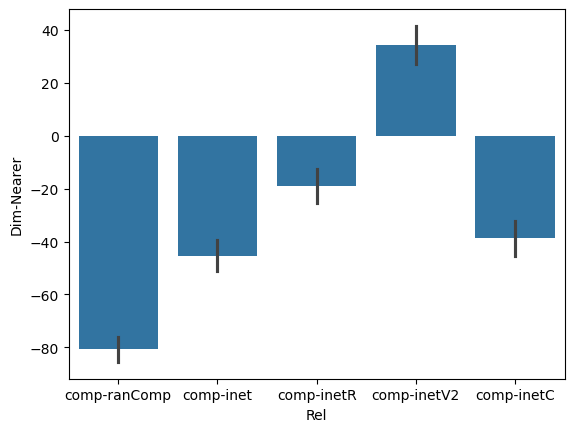

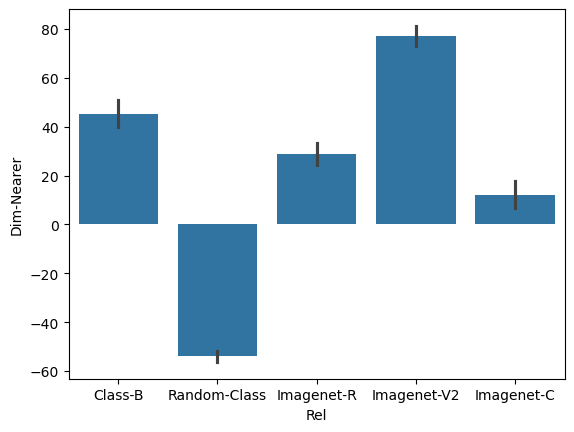

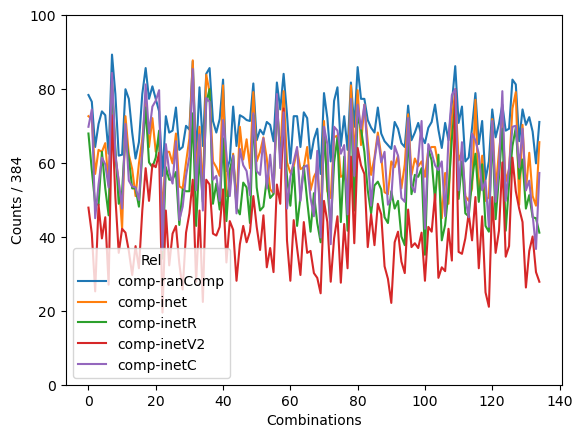

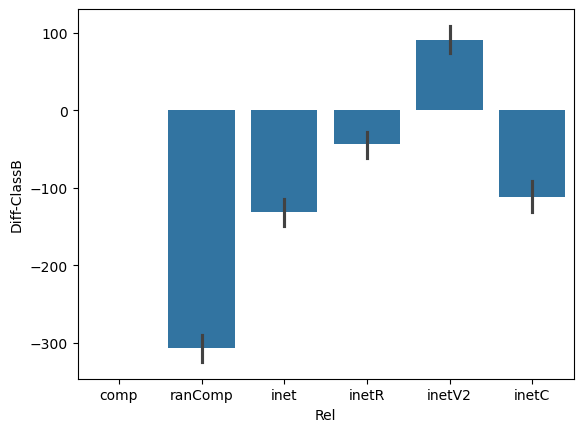

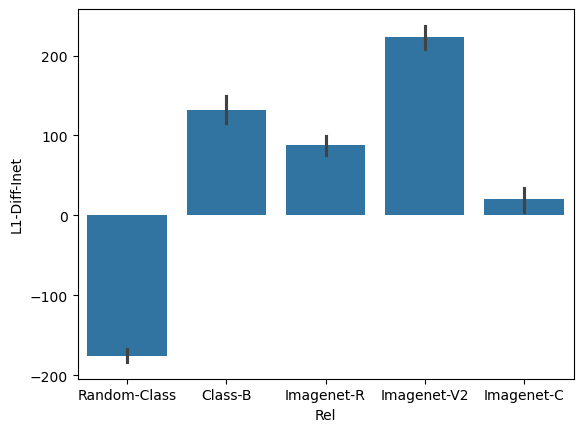

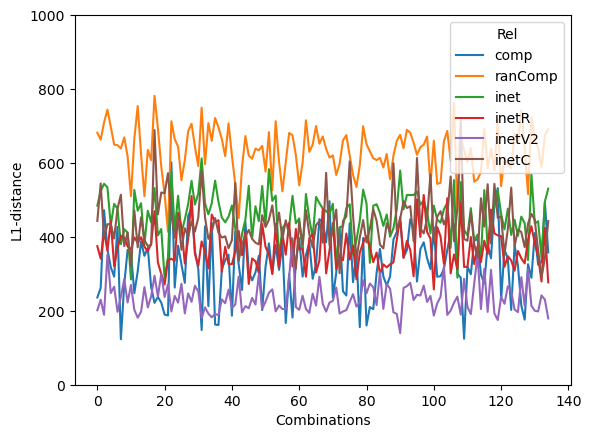

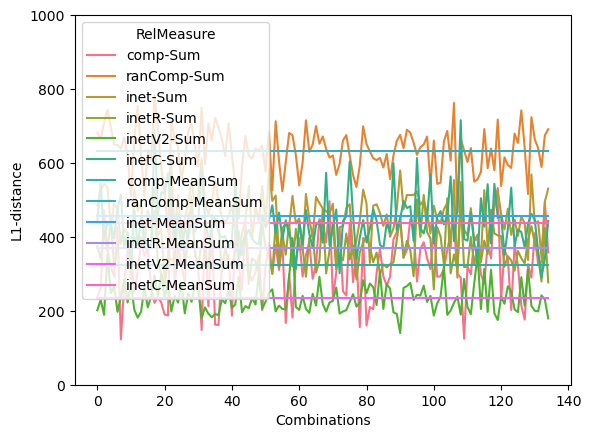

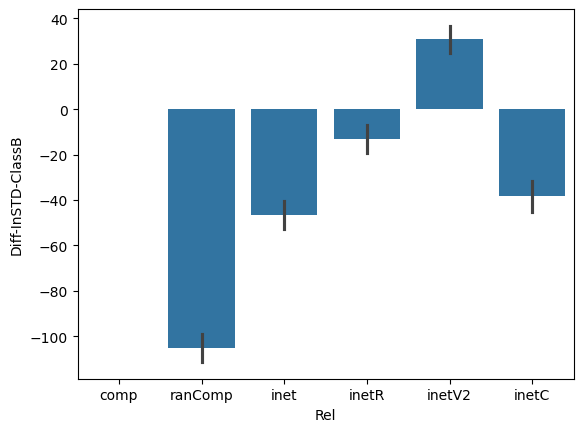

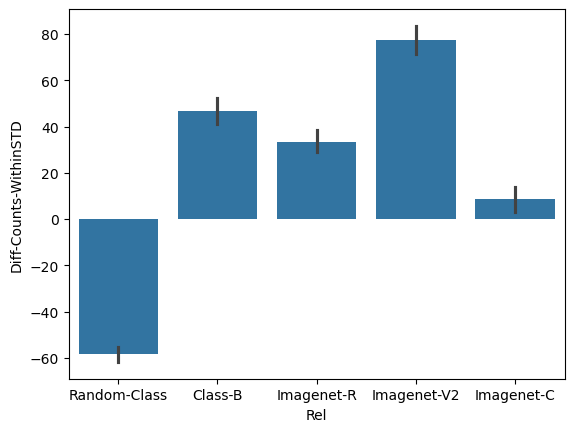

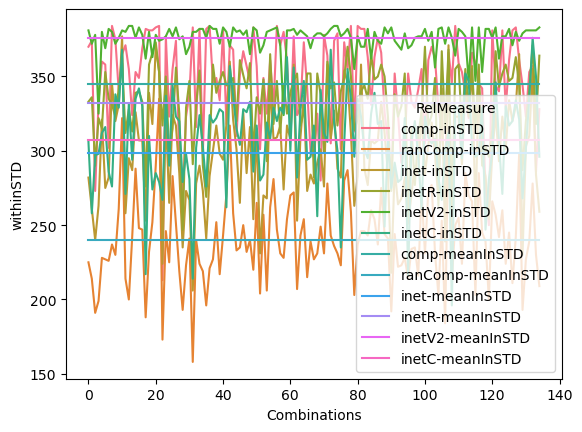

In [18]:
 # visualize statistics 

sns.barplot(data=diff_counts_df, x='Rel', y='Dim-Nearer')
plt.show()

sns.barplot(data=diff_inet_counts_df, x='Rel', y='Dim-Nearer')
plt.show()

plt.ylim(0,100)
ax = sns.lineplot(data=diff_counts_df, x='Comb', y='Val', hue='Rel')
ax.set(xlabel = 'Combinations', ylabel= 'Counts / 384')
plt.show()

sns.barplot(data=diff_sum_df, x='Rel', y='Diff-ClassB')
plt.show()

sns.barplot(data=diff_l1_inet_df, x='Rel', y='L1-Diff-Inet')
plt.show()

plt.ylim(0,1000)
ax = sns.lineplot(data=diff_sum_df, x='Comb', y='Sum', hue='Rel')
ax.set(xlabel='Combinations', ylabel='L1-distance')
plt.show()

sum_mean_combined = diff_sum_df.melt(id_vars=['Comb', 'Rel'], var_name='Measure', value_vars=['Sum', 'MeanSum'])
sum_mean_combined['RelMeasure'] = sum_mean_combined['Rel'] + '-' + sum_mean_combined['Measure']

plt.ylim(0,1000)
ax = sns.lineplot(data=sum_mean_combined, x='Comb', y='value', hue='RelMeasure', legend=True)
ax.set(xlabel='Combinations', ylabel='L1-distance')
plt.show()

sns.barplot(data=within_std_df, x='Rel', y='Diff-InSTD-ClassB')
plt.show()

sns.barplot(data=within_std_inet_df, x='Rel', y='Diff-Counts-WithinSTD')
plt.show()

in_std_with_mean = within_std_df.melt(id_vars=['Comb', 'Rel'], var_name = 'Measure', value_vars=['inSTD', 'meanInSTD'])
in_std_with_mean['RelMeasure'] = in_std_with_mean['Rel'] + '-' + in_std_with_mean['Measure']

ax = sns.lineplot(data=in_std_with_mean, x = 'Comb', y='value', hue='RelMeasure', legend=True)
ax.set(xlabel='Combinations', ylabel='withinSTD')
plt.show()

In [41]:
# identify 50% of worst id-ood matches regarding mean distance 
# 

sum_combination_dict = dict()

for combination in all_combinations:
    sum_combination_dict[float(statistics_dict[combination]['id_sum'])] = combination 

sorted_dict = sorted(sum_combination_dict)
print(sorted_dict)

worst_id_ood_matches = []
for p, diff_sum in enumerate(sorted_dict):

    ood_wnid, id_wnid, ran_wnid = sum_combination_dict[diff_sum]
    id_name = semantic_info.wnid_to_classname[id_wnid]
    ood_name = semantic_info.wnid_to_classname[ood_wnid]

    print(f'{p}: Scored {diff_sum:.2e}: OOD = {ood_name}, ID = {id_name}')

print(f'Combinations printed: {len(sorted_dict)} from possible {len(all_combinations)} combinations.')

[285.52801513671875, 289.4336853027344, 292.9093017578125, 306.568359375, 309.7046203613281, 342.04351806640625, 364.65673828125, 364.68670654296875, 366.841552734375, 384.62213134765625, 399.7071838378906, 410.1962890625, 426.5854797363281, 427.532958984375, 434.56048583984375, 445.22161865234375, 470.74700927734375, 488.12548828125, 493.9937744140625, 502.389892578125, 508.62213134765625, 517.4906005859375, 528.6527099609375, 531.45068359375, 536.09912109375, 544.8900146484375, 554.5610961914062, 560.0919189453125, 565.3636474609375, 585.909912109375, 601.3419189453125, 618.6402587890625, 628.5443115234375, 641.086669921875, 641.65869140625, 643.666015625, 645.576904296875, 674.760986328125, 693.0130615234375, 693.08740234375]
0: Scored 2.86e+02: OOD =  Standard Poodle, ID =  Toy Poodle
1: Scored 2.89e+02: OOD =  cheetah, ID =  leopard
2: Scored 2.93e+02: OOD =  Whippet, ID =  Italian Greyhound
3: Scored 3.07e+02: OOD =  gorilla, ID =  orangutan
4: Scored 3.10e+02: OOD =  chimpanzee,

In [ ]:
# for each ood-class, find closest class in rest of imagenet-1k (999 candidates)

ood_class_comparisons = dict()
all_ood_wnids = [id_ood[0] for id_ood in class_splits]
imagenet_wnids = list(imagenet_x_val_results.keys())

print(f'Number of detected ood-wnids: {len(all_ood_wnids)}')
print(f'Number of detected imagenet-wnids: {len(imagenet_wnids)}')

for ood_wnid in all_ood_wnids:

    # calculate mean of model-output for this class 
    ood_mean = np.mean(imagenet_x_val_results[ood_wnid], axis=0)

    imagenet_wnids.remove(ood_wnid)
    for class_wnid in imagenet_wnids: 

        # calculate mean of selected class
        class_mean = np.mean(imagenet_x_val_results[class_wnid], axis=0)
        diff_ood = np.abs(ood_mean - class_mean)
        sum_class_diff = np.sum(diff_ood)
        try:
            ood_class_comparisons[ood_wnid].append((sum_class_diff, class_wnid))
        except KeyError:
            ood_class_comparisons[ood_wnid] = [(sum_class_diff, class_wnid)]

    # sort calculated mean differences
    ood_class_comparisons[ood_wnid].sort(key = lambda ood_id: ood_id[0])
    
    imagenet_wnids.append(ood_wnid)

Number of detected ood-wnids: 40
Number of detected imagenet-wnids: 1000
Total compare classes for n01616318: 999
Total compare classes for n02106550: 999
Total compare classes for n02096585: 999
Total compare classes for n02112137: 999
Total compare classes for n02091134: 999
Total compare classes for n02086240: 999
Total compare classes for n02056570: 999
Total compare classes for n02480855: 999
Total compare classes for n01534433: 999
Total compare classes for n02749479: 999
Total compare classes for n02108915: 999
Total compare classes for n02481823: 999
Total compare classes for n01694178: 999
Total compare classes for n02236044: 999
Total compare classes for n02423022: 999
Total compare classes for n02113799: 999
Total compare classes for n02814860: 999
Total compare classes for n01632777: 999
Total compare classes for n01986214: 999
Total compare classes for n02097298: 999
Total compare classes for n02098286: 999
Total compare classes for n02066245: 999
Total compare classes for

In [50]:
# print closest compare classes for each ood-class

for ood_wnid in all_ood_wnids: 

    top_five = ood_class_comparisons[ood_wnid][:5]
    top_five_names = [(semantic_info.wnid_to_classname[wnid], score) for score, wnid in top_five]
    ood_name = semantic_info.wnid_to_classname[ood_wnid]
    print(f'OOD = {ood_name}: {top_five_names}')


OOD =  vulture: [(' bald eagle', np.float32(364.6867)), (' kite (bird of prey)', np.float32(374.1024)), (' hornbill', np.float32(427.8051)), (' ptarmigan', np.float32(438.59735)), (' black stork', np.float32(446.6934))]
OOD =  Rottweiler: [(' Black and Tan Coonhound', np.float32(247.84436)), (' Dobermann', np.float32(274.29382)), (' Miniature Pinscher', np.float32(354.40723)), (' Greater Swiss Mountain Dog', np.float32(369.6695)), (' Entlebucher Sennenhund', np.float32(377.0548))]
OOD =  Boston Terrier: [(' French Bulldog', np.float32(313.06226)), (' Staffordshire Bull Terrier', np.float32(401.3598)), (' Boxer', np.float32(438.5884)), (' American Staffordshire Terrier', np.float32(439.02612)), (' toy terrier', np.float32(443.41534))]
OOD =  Chow Chow: [(' Pomeranian', np.float32(366.84155)), (' Keeshond', np.float32(374.4064)), (' Samoyed', np.float32(429.12982)), (' Pekingese', np.float32(445.51138)), (' Great Pyrenees dog', np.float32(469.20425))]
OOD =  Whippet: [(' Ibizan Hound', n